In [1]:
import pandas as pd
import numpy as np

# 데이터 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 가설검정 및 통계 분석 패키지
from scipy import stats

# 선형모델 formula ( y ~ x1 + x2 + ...)
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

from sklearn.linear_model import LinearRegression
from statsmodels.api import qqplot, add_constant

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.anova import anova_lm

# 변수 선택법(후진제거법)
from sklearn.feature_selection import RFE

# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Scale변환 -> 표준화 회귀계수 산출
## coefficient를 표준화해서 비교해본다.
from sklearn.preprocessing import StandardScaler

# grhpviz
from sklearn.tree import export_graphviz

import graphviz

from sklearn.model_selection import train_test_split

# 앙상블 모델
from sklearn.ensemble import GradientBoostingRegressor as GBR

from sklearn.model_selection import GridSearchCV


# 주피터 노트북 사용시 그래프 자동 출력 옵션
%matplotlib inline

# 폰트 설정
matplotlib.rc('font', family = "NanumGothic")
plt.rc('font', family = "NanumGothic")
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df_raw = pd.read_csv("./Data/체질검사.csv")

df_raw_y = df_raw["FAT"]
df_raw_x = df_raw.drop("FAT", axis=1, inplace = False)

- train_test_split (7:3으로 트레인과 테스트 데이터가 나눠진다.)

In [3]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, 
                                                                test_size=0.3, random_state=1234)

print("train data X size: {}".format(df_train_x.shape))
print("train data Y size: {}".format(df_train_y.shape))
print("test data X size: {}".format(df_test_x.shape))
print("test data Y size: {}".format(df_test_y.shape))

train data X size: (176, 13)
train data Y size: (176,)
test data X size: (76, 13)
test data Y size: (76,)


# Gradient Boosting Regression

In [1]:
gb_uncustomized = GBR(random_state=1234)
gb_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(gb_uncustomized.score(df_train_x, df_train_y)))

#test데이터 설명력
print("Score on test set: {:.3f}".format(gb_uncustomized.score(df_test_x, df_test_y)))

NameError: name 'GBR' is not defined

※ test데이터의 설명력이 상대적으로 낮음: 과대적합

## 2. 파라미터 변경

- n_estimators: 트리 수 변경에 따른 모델 성능

In [7]:
train_score = []; test_score = []

para_n_tree = [n_tree * 10 for n_tree in range(1, 11)]

for v_n_estimators in para_n_tree:
    gb = GBR(random_state=1234, n_estimators = v_n_estimators)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["n_estimators"] = para_n_tree
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

In [8]:
df_score_leaf.round(3)

# Train과 Test Score의 Gap이 크다면 모델이 불안정한 것으로 볼 수 있다.

,n_estimators,TrainScore,TestScore
0,10,0.712,0.512
1,20,0.850,0.589
2,30,0.897,0.600
3,40,0.921,0.599
4,50,0.942,0.587
5,60,0.954,0.586
6,70,0.963,0.587
7,80,0.970,0.581
8,90,0.976,0.582
9,100,0.981,0.581


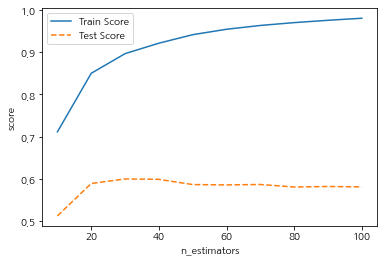

In [9]:
plt.plot(para_n_tree, train_score, linestyle="-", label = "Train Score")
plt.plot(para_n_tree, test_score, linestyle="--", label = "Test Score")
plt.xlabel("n_estimators")
plt.ylabel("score")
plt.legend()

- 30정도가 괜찮아 보인다.

- min_samples_leaf: 잎사귀 노드의 최소 자료 수

In [18]:
train_score = []; test_score = []

para_leaf = [n_leaf * 1 for n_leaf in range(1, 21)]

for v_min_samples_leaf in para_leaf:
    gb = GBR(random_state=1234, n_estimators = 30, min_samples_leaf = v_min_samples_leaf)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

In [19]:
# 모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.897,0.600
1,2,0.899,0.599
2,3,0.896,0.594
3,4,0.893,0.586
4,5,0.890,0.604
5,6,0.888,0.596
6,7,0.884,0.590
7,8,0.874,0.610
8,9,0.879,0.598
9,10,0.873,0.587


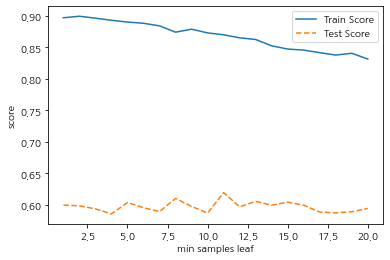

In [20]:
plt.plot(para_leaf, train_score, linestyle="-", label = "Train Score")
plt.plot(para_leaf, test_score, linestyle="--", label = "Test Score")
plt.xlabel("min samples leaf")
plt.ylabel("score")
plt.legend()


- 11정도에서 가장 괜찮아 보인다.

- min_samples_split: 분리 노드의 최소 자료 수 변경

In [21]:
train_score = []; test_score = []

para_split = [n_split * 2 for n_split in range(2, 21)]

for v_min_samples_split in para_split:
    gb = GBR(random_state=1234, n_estimators = 30, min_samples_leaf = 11, 
             min_samples_split=v_min_samples_split)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesSplit"] = para_split
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

In [22]:
# 모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.870,0.620
1,6,0.870,0.620
2,8,0.870,0.620
3,10,0.870,0.620
4,12,0.870,0.620
5,14,0.870,0.620
6,16,0.870,0.620
7,18,0.870,0.620
8,20,0.870,0.620
9,22,0.870,0.620


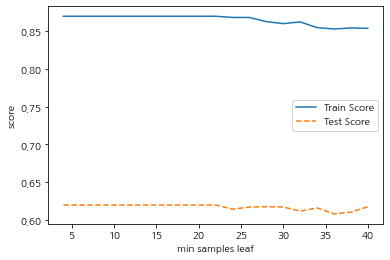

In [23]:
plt.plot(para_split, train_score, linestyle="-", label = "Train Score")
plt.plot(para_split, test_score, linestyle="--", label = "Test Score")
plt.xlabel("min samples split")
plt.ylabel("score")
plt.legend()

※ 분리 노드 최소 자료 수 증가에 따라 모델의 설명력은 감소한다.  따라서 데이터의 성능변화를 고려해 13~14정도를 선정한다.

- MaxDepth: 최대 깊이 변경에 따른 모델 성능

In [33]:
train_score = []; test_score = []

para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb = GBR(random_state=1234, n_estimators = 30, min_samples_leaf = 11, 
             min_samples_split=22, max_depth=v_max_depth)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["Maxdepth"] = para_depth
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

In [34]:
# 모델 설명력 확인
df_score_leaf.round(3)

,Maxdepth,TrainScore,TestScore
0,1,0.703,0.592
1,2,0.800,0.600
2,3,0.870,0.620
3,4,0.900,0.629
4,5,0.913,0.613
5,6,0.917,0.614
6,7,0.920,0.613
7,8,0.920,0.615
8,9,0.921,0.609
9,10,0.922,0.616


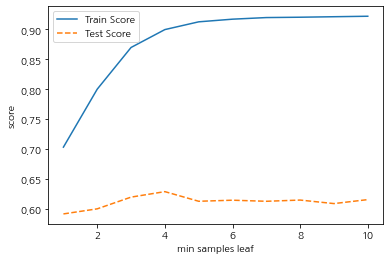

In [35]:
plt.plot(para_depth, train_score, linestyle="-", label = "Train Score")
plt.plot(para_depth, test_score, linestyle="--", label = "Test Score")
plt.xlabel("maxdepth")
plt.ylabel("score")
plt.legend()

※ 4정도로 가져가면 좋아 보인다.

Learning_rate(학습률)

In [36]:
train_score = []; test_score = []

para_lr = [lr*0.1 for lr in range(1, 10)]

for v_learning_rate in para_lr:
    gb = GBR(random_state=1234, n_estimators = 30, min_samples_leaf = 11, 
             min_samples_split=22, max_depth=4, learning_rate=v_learning_rate)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["LearningRate"] = para_lr
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

In [37]:
# 모델 설명력 확인
df_score_leaf.round(3)

,Maxdepth,TrainScore,TestScore
0,0.1,0.900,0.629
1,0.2,0.940,0.588
2,0.3,0.966,0.566
3,0.4,0.981,0.539
4,0.5,0.984,0.533
5,0.6,0.990,0.527
6,0.7,0.993,0.478
7,0.8,0.994,0.437
8,0.9,0.997,0.464


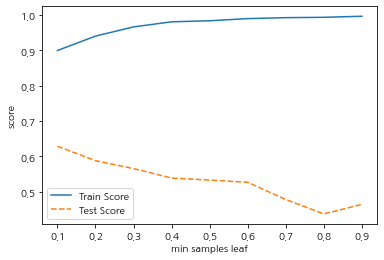

In [38]:
plt.plot(para_lr, train_score, linestyle="-", label = "Train Score")
plt.plot(para_lr, test_score, linestyle="--", label = "Test Score")
plt.xlabel("LearningRate")
plt.ylabel("score")
plt.legend()

※ 학습률 증가에 따라 모델의 설명력은 증가하는데, 반면 test데이터의 성능은 급격하게 저하되므로 0.1을 선택한다.

## 3. 결론 도출

In [39]:
gb_final = GBR(random_state=1234, n_estimators = 30, min_samples_leaf = 11, 
             min_samples_split=22, max_depth=4, learning_rate=0.1)
gb_final.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(gb_final.score(df_train_x, df_train_y)))

#test데이터 설명력
print("Score on test set: {:.3f}".format(gb_final.score(df_test_x, df_test_y)))

Score on training set: 0.900
Score on test set: 0.629


※ 파라미터 튜닝 전과 test셋이 차이가 난다. 파라미터 튜닝으로 성능을 올릴 수 있었다.

## 4. 결론 도출_설명변수 중요도
- feature_importances_: 설명변수의 중요도

In [41]:
v_feature_name = df_train_x.columns
df_importance = pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"] = gb_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
5,ABDOMEN,0.775
2,HEIGHT,0.038
12,WRIST,0.025
3,NECK,0.023
6,HIP,0.021
4,CHEST,0.021
0,AGE,0.021
7,THIGH,0.020
8,KNEE,0.017
10,BICEPS,0.014


Text(0, 0.5, '변수(feature)')

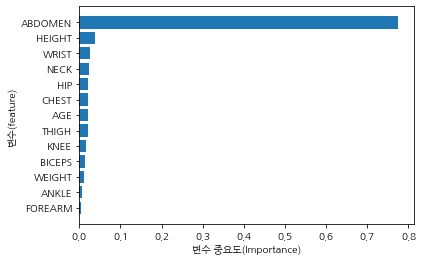

In [42]:
df_importance.sort_values("Importance", ascending= True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도(Importance)")
plt.ylabel("변수(feature)")

※ 중요설명변수: 복부둘레, 키, 손목 둘레 순으로 영향이 크다고 해석할 수 있다. 단, 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 데이터예 따라 중요도가 변경될 수 있다.